In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv


In [2]:
import pandas as pd
import os

# Check available files
print("Available files:")
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Load and examine the data
fake_df = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv')
real_df = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/True.csv')

print(f"\nFake news shape: {fake_df.shape}")
print(f"Real news shape: {real_df.shape}")
print(f"\nFake news columns: {fake_df.columns.tolist()}")
print(f"Real news columns: {real_df.columns.tolist()}")

# Preview data
print("\n--- Fake News Sample ---")
print(fake_df.head(2))
print("\n--- Real News Sample ---")
print(real_df.head(2))

Available files:
/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv

Fake news shape: (23481, 4)
Real news shape: (21417, 4)

Fake news columns: ['title', 'text', 'subject', 'date']
Real news columns: ['title', 'text', 'subject', 'date']

--- Fake News Sample ---
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  

--- Real News Sample ---
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   

                                                text       su

In [3]:
import os

print("=== EXPLORING KAGGLE INPUT DIRECTORY ===")
for root, dirs, files in os.walk('/kaggle/input'):
    level = root.replace('/kaggle/input', '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files:
        print(f'{subindent}{file}')

=== EXPLORING KAGGLE INPUT DIRECTORY ===
input/
  fake-and-real-news-dataset/
    True.csv
    Fake.csv


In [5]:
# Combine and preprocess data
def preprocess_data(fake_df, real_df):
    # Add labels
    fake_df['label'] = 1
    real_df['label'] = 0
    
    # Combine
    df = pd.concat([fake_df, real_df], ignore_index=True)
    
    # Create combined text
    df['combined_text'] = df['title'].fillna('') + ' ' + df['text'].fillna('')
    
    # Remove source patterns to prevent data leakage
    patterns_to_remove = [
        r'WASHINGTON \(Reuters\)',
        r'LONDON \(Reuters\)',
        r'NEW YORK \(Reuters\)',
        r'\(Reuters\)',
        r'By \w+ \w+'
    ]
    
    for pattern in patterns_to_remove:
        df['combined_text'] = df['combined_text'].str.replace(pattern, '', regex=True)
    
    # Clean text
    df['combined_text'] = df['combined_text'].str.strip()
    df = df[df['combined_text'].str.len() > 50]
    
    print(f"Final dataset size: {len(df)}")
    return df

df = preprocess_data(fake_df, real_df)

Final dataset size: 44886


In [6]:
# === SECTION 1: SETUP & DATA EXPLORATION ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

# Find dataset paths
print("=== FINDING DATASET ===")
fake_path = None
real_path = None

for root, dirs, files in os.walk('/kaggle/input'):
    for file in files:
        if file.lower() == 'fake.csv':
            fake_path = os.path.join(root, file)
        elif file.lower() == 'true.csv':
            real_path = os.path.join(root, file)

print(f"Fake: {fake_path}")
print(f"Real: {real_path}")

# Load data
fake_df = pd.read_csv(fake_path)
real_df = pd.read_csv(real_path)

print(f"\n=== DATASET INFO ===")
print(f"Fake articles: {len(fake_df)}")
print(f"Real articles: {len(real_df)}")
print(f"Columns: {fake_df.columns.tolist()}")

# Quick preview
print(f"\n=== SAMPLE DATA ===")
print("Fake news sample:")
print(fake_df[['title', 'text']].head(2))
print("\nReal news sample:")
print(real_df[['title', 'text']].head(2))

=== FINDING DATASET ===
Fake: /kaggle/input/fake-and-real-news-dataset/Fake.csv
Real: /kaggle/input/fake-and-real-news-dataset/True.csv

=== DATASET INFO ===
Fake articles: 23481
Real articles: 21417
Columns: ['title', 'text', 'subject', 'date']

=== SAMPLE DATA ===
Fake news sample:
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   

                                                text  
0  Donald Trump just couldn t wish all Americans ...  
1  House Intelligence Committee Chairman Devin Nu...  

Real news sample:
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   

                                                text  
0  WASHINGTON (Reuters) - The head of a conservat...  
1  WASHINGTON (Reuters) - Transgender people will...  


In [7]:
# === SECTION 2: DATA PREPROCESSING ===
from sklearn.model_selection import train_test_split

def preprocess_data(fake_df, real_df):
    # Add labels
    fake_df = fake_df.copy()
    real_df = real_df.copy()
    fake_df['label'] = 1  # Fake
    real_df['label'] = 0  # Real
    
    # Combine datasets
    df = pd.concat([fake_df, real_df], ignore_index=True)
    
    # Create combined text
    df['combined_text'] = df['title'].fillna('') + ' ' + df['text'].fillna('')
    
    # Remove source patterns (data leakage prevention)
    patterns = [
        r'WASHINGTON \(Reuters\)',
        r'LONDON \(Reuters\)', 
        r'NEW YORK \(Reuters\)',
        r'\(Reuters\)',
        r'By \w+ \w+'
    ]
    
    for pattern in patterns:
        df['combined_text'] = df['combined_text'].str.replace(pattern, '', regex=True)
    
    # Clean text
    df['combined_text'] = df['combined_text'].str.strip()
    df = df[df['combined_text'].str.len() > 50]
    
    return df

# Process data
df = preprocess_data(fake_df, real_df)
print(f"Processed dataset size: {len(df)}")
print(f"Label distribution:\n{df['label'].value_counts()}")

# Create train/test split (save for later)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

Processed dataset size: 44886
Label distribution:
label
1    23470
0    21416
Name: count, dtype: int64
Train size: 35908, Test size: 8978


In [8]:
# === SECTION 3: IMPORT TRANSFORMERS & TEST ===
import torch
from torch.utils.data import DataLoader, Dataset

# Import transformers
from transformers import (
    DistilBertTokenizer, 
    DistilBertForSequenceClassification,
    get_linear_schedule_with_warmup
)

# Import optimizer (compatible way)
try:
    from transformers import AdamW
except ImportError:
    from torch.optim import AdamW

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Test model loading (this will download the model - only do once)
MODEL_NAME = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)
model = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

print("✅ Model and tokenizer loaded successfully!")
print(f"Model size: {sum(p.numel() for p in model.parameters())/1e6:.1f}M parameters")

2025-08-01 13:43:16.318933: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754055796.543569      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754055796.605385      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


PyTorch version: 2.6.0+cu124
CUDA available: True


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model and tokenizer loaded successfully!
Model size: 67.0M parameters


In [11]:
# === SECTION 4: DATASET CLASS & SMALL TEST ===
from torch.utils.data import Dataset

class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Test with small sample
small_sample = train_df.head(10)
test_dataset = NewsDataset(
    small_sample['combined_text'].values,
    small_sample['label'].values,
    tokenizer,
    max_length=256  # Smaller for testing
)

print(f"Test dataset created with {len(test_dataset)} samples")

# Test one sample
sample = test_dataset[0]
print(f"Sample shape - Input IDs: {sample['input_ids'].shape}")
print(f"Sample shape - Attention Mask: {sample['attention_mask'].shape}")
print(f"Sample label: {sample['labels']}")

Test dataset created with 10 samples
Sample shape - Input IDs: torch.Size([256])
Sample shape - Attention Mask: torch.Size([256])
Sample label: 0


In [12]:
# === SECTION 5: QUICK TRAINING TEST ===
from torch.utils.data import DataLoader
from tqdm import tqdm

# Create small training set for testing
small_train = train_df.head(100)  # Just 100 samples for quick test
train_dataset = NewsDataset(
    small_train['combined_text'].values,
    small_train['label'].values,
    tokenizer,
    max_length=256
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Setup model for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

print(f"Using device: {device}")
print(f"Training on {len(train_dataset)} samples")

# Quick training loop (1 epoch, few batches)
model.train()
total_loss = 0
num_batches = min(5, len(train_loader))  # Only 5 batches for testing

for i, batch in enumerate(train_loader):
    if i >= num_batches:
        break
        
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    
    optimizer.zero_grad()
    
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    total_loss += loss.item()
    
    loss.backward()
    optimizer.step()
    
    print(f"Batch {i+1}/{num_batches}, Loss: {loss.item():.4f}")

avg_loss = total_loss / num_batches
print(f"✅ Quick test completed! Average loss: {avg_loss:.4f}")

Using device: cuda
Training on 100 samples
Batch 1/5, Loss: 0.7069
Batch 2/5, Loss: 0.6954
Batch 3/5, Loss: 0.7148
Batch 4/5, Loss: 0.6784
Batch 5/5, Loss: 0.6519
✅ Quick test completed! Average loss: 0.6895


In [13]:
# === SECTION 6: FULL TRAINING ===
# Only run this after confirming everything works in previous sections

# Configuration
BATCH_SIZE = 16
MAX_LENGTH = 512
EPOCHS = 3
LEARNING_RATE = 2e-5

# Create full datasets
train_dataset = NewsDataset(train_df['combined_text'].values, train_df['label'].values, tokenizer, MAX_LENGTH)
test_dataset = NewsDataset(test_df['combined_text'].values, test_df['label'].values, tokenizer, MAX_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Reinitialize model for full training
model = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model.to(device)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=500,
    num_training_steps=len(train_loader) * EPOCHS
)

# Training loop
for epoch in range(EPOCHS):
    print(f"\n=== EPOCH {epoch+1}/{EPOCHS} ===")
    model.train()
    total_loss = 0
    
    progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        
        loss = outputs.loss
        total_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'loss': loss.item()})
    
    avg_loss = total_loss / len(train_loader)
    print(f"Average training loss: {avg_loss:.4f}")
    
    # Save checkpoint
    torch.save(model.state_dict(), f'model_epoch_{epoch+1}.pth')
    print(f"Model saved for epoch {epoch+1}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== EPOCH 1/3 ===


Training Epoch 1: 100%|██████████| 2245/2245 [35:18<00:00,  1.06it/s, loss=6.08e-5] 


Average training loss: 0.0497
Model saved for epoch 1

=== EPOCH 2/3 ===


Training Epoch 2: 100%|██████████| 2245/2245 [35:33<00:00,  1.05it/s, loss=2.04e-5] 


Average training loss: 0.0015
Model saved for epoch 2

=== EPOCH 3/3 ===


Training Epoch 3: 100%|██████████| 2245/2245 [35:33<00:00,  1.05it/s, loss=1.25e-5] 


Average training loss: 0.0005
Model saved for epoch 3


Evaluating: 100%|██████████| 562/562 [03:28<00:00,  2.70it/s]


Test Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

        Real       1.00      1.00      1.00      4284
        Fake       1.00      1.00      1.00      4694

    accuracy                           1.00      8978
   macro avg       1.00      1.00      1.00      8978
weighted avg       1.00      1.00      1.00      8978



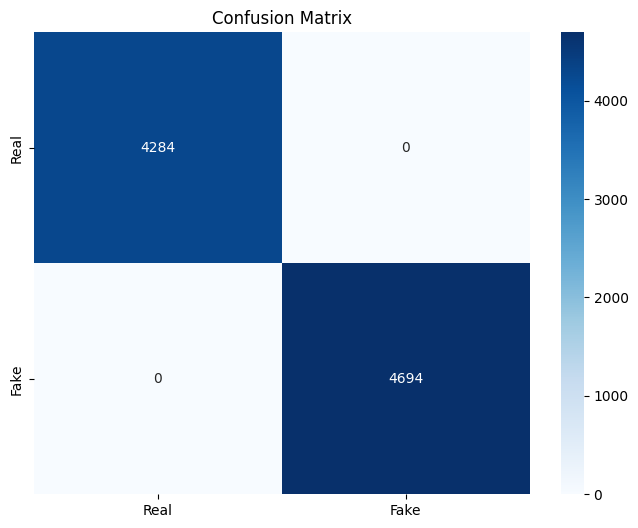

In [14]:
# === SECTION 7: EVALUATION ===
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def evaluate_model(model, test_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(true_labels, predictions)
    return accuracy, predictions, true_labels

# Evaluate
accuracy, preds, true_labels = evaluate_model(model, test_loader, device)
print(f"Test Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(true_labels, preds, target_names=['Real', 'Fake']))

# Confusion Matrix
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.show()